# Anxiety of Conception Algorithm

This notebook contains the code and explanation for how the poems of my book, "The Anxiety of Conception," are ordered. 

I wrote one hundred prose poems (single paragraphs) in the year prior to J's birth, and one hundred in the year after. Let's call these two sets of poems **poems a** (pre-birth poems) and **poems b** (post-birth poems). The book also has two parts: *PART 1* and *PART 2*. In the first printings, most poems from **poems a** are in *PART 1*, but over time the poems begin to swap and get muddled, such that by the 100th book the poems are mostly shuffled.

How are the poems shuffled? There is an algorithm which calculates a score for how "well" a poem would go after another one. Some poems go well together---these get a low score (or `small distance`; this terminology will be explained later)---others don't match very well and get a high score (or `large distance`). As books are printed, poems are rearranged according to this score, such that poems that go "well" together according to their score are adjacent, even if very far apart in the original ordering.

## Step 1: Import the poems

### Text import

Import poems from **poems a** and **poems b**. Subset each set to just 100 poems each. (Eventually there should just be exactly 100 poems in each part.) Then put them together into one large list which is referenced for the rest of the code, and just know that the first 100 are from **poems a** and the second 100 from **poems b**.

The output of the algorithm which creates books will be an ordering: this will be a list of indices of this original list of poems. i.e. There are poems 0, 1, 2, 3, 4, ... 199. The output will be a list something like 5, 90, 23, 1, ... 182, representing the order in which the poems should be printed in the book.

Note that the imported text looks something like:

```
[1] Poem text here.

[2] Another poem text here.
```

Right now I'm removing the numbers in brackets, but I may consider putting them back later.

### Words and stems

In addition to tracking the raw text of each poem, I also split each poem into a list of lowercase words with punctuation removed, and a list of word stems (e.g. instead of "computer" the word becomes the stem "comput"). This is then used when calculating the score (or distance) between poems, as described later.

In [1]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()

def simple_tokenize(s):
    """where s is a string of text, raw poem"""
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.split(" ")

def get_stems(s):
    """where s is a list of lowercase words"""
    return [stemmer.stem(w) for w in s]


data_raw = []
data_tokens = []
data_stems = []

# first add part a
with open("part_a.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)

            tokens = simple_tokenize(text)
            data_tokens.append(tokens)

            stems = get_stems(tokens)
            data_stems.append(stems)

# cut it to just 100 poems
data_raw = data_raw[:100]
data_tokens = data_tokens[:100]
data_stems = data_stems[:100]

poems_a = list(range(len(data_raw)))
            
# then add part b
with open("part_b.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)

            tokens = simple_tokenize(text)
            data_tokens.append(tokens)

            stems = get_stems(tokens)
            data_stems.append(stems)

data_raw = data_raw[:200]
data_tokens = data_tokens[:200]
data_stems = data_stems[:200]            

poems_b = list(range(poems_a[-1]+1, len(data_raw)))

split_index = poems_a[-1] + 1

print(poems_a)
print(poems_b)
print(split_index)
data_raw[0], ' '.join(data_tokens[0]), ' '.join(data_stems[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
100


('I visualize two paths my life might take. The one where I have a child and the one where I do not. I try to place them on equal footing, imagining each as something I truly want. Though I know both will be filled with disappointment and loss.',
 'i visualize two paths my life might take the one where i have a child and the one where i do not i try to place them on equal footing imagining each as something i truly want though i know both will be filled with disappointment and loss',
 'i visual two path my life might take the one where i have a child and the one where i do not i tri to place them on equal foot imagin each as someth i truli want though i know both will be fill with disappoint and loss')

## Step 2: Calculate transition scores

i.e. How well one poem flows into another. 

Look at the 10 words at the end of one poem, the 10 at the start of the next. High score is better, but then we'll invert it so that score is more like distance (where lower is better).

Initial score: 0

If a word in poem B is in poem A:

* If not a stop word:
    * +10 if exact word match OR
    * +5 if stemmed word match
* If narrow stop word:
    * +2
* If broad stop word
    * +4
    
Not implemented: 

* Check number of words between them (k) -- could be up to 18
    * -k/4

I'd like this score to be a bit cleaner, and maybe consider distance between words, but this is working pretty well for now.

In [3]:
stopwords_broad = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stopwords_narrow = ["the", "a", "an"]

def join_score(a, b, n=10):
    """where a and b are indices for the data, and n is num of words to consider"""
    score = 0
    a_tokens = data_tokens[a]
    a_stems = data_stems[a]
    b_tokens = data_tokens[b]
    b_stems = data_stems[b]
    for i in range(min(len(a_tokens), n)): # iterate over words in a
        a_token = a_tokens[-i]
        a_stem = a_stems[-i]
        for j in range(min(len(b_tokens), n)): # iterate over words in b
            b_token = b_tokens[j]
            b_stem = b_stems[j]
            if a_token == b_token: # if there's a matching word
                if a_token in stopwords_narrow:
                    score += 2
                    continue
                if a_token in stopwords_broad:
                    score += 4
                    continue
                score += 10
                continue
            if a_stem == b_stem:
                score += 5
    return 20 - score

p = 2
q = 3
print(data_raw[p], "\n")
print(data_raw[q])
join_score(p, q)

A mood sweeps in like a fog. I no longer know where it came from. I get stuck in circles. I try to ignore the suspense; anger and hurt can do that well, but not entirely. Suspense is lodged within me, someplace deep. The fog crawls at my feet. Let me stay, it mews, and though I definitely want it to leave, it doesn’t feel entirely up to me. 

I pause to look carefully at the book cover. I am obsessed with the way books feel, how they look. Their aspect ratio, the texture of the paper. If I put my nose close, I can see the dot matrix of the printed artwork. It’s not grey; it’s white with a multitude of black dots.


12

Calculate the score for all possible pairs of poems. This results in a square matrix the size of how many poems there are (200).

In [4]:
import numpy as np

def calc_all_scores(data, join_score_func):
    scores = np.empty([len(data), len(data)])
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                s = np.nan
            else:
                s = join_score_func(i, j)
            scores[i][j] = s
    return scores

scores = calc_all_scores(data_raw, join_score)

scores

array([[nan,  6., 16., ..., 12., 16., 12.],
       [12., nan, 16., ...,  8., 20., 16.],
       [20., 12., nan, ...,  6., 18., 18.],
       ...,
       [18., 18., 20., ..., nan, 16., 20.],
       [16., 16., 16., ..., 12., nan,  8.],
       [16., 16., 12., ..., 12., 14., nan]])

## Step 2a: See which poems fit together best

This is just to check that the join scores are working okay.

Remember: lower is better, because the scores are considered as `distances` between the poems.

In [5]:
def get_top_scores(scores, asc=True, n=5):
    flattened = scores.flatten()
    if asc:
        sorted_indices = np.argsort(flattened)
    else:
        sorted_indices = np.argsort(-flattened)
    indices_2d = np.unravel_index(sorted_indices, scores.shape)
    sorted_indices_list = list(zip(indices_2d[0], indices_2d[1]))
    
    for i, val in enumerate(sorted_indices_list[0:n]):
        print('indices:', val)
        print('score:', scores[val[0],val[1]])
        print('>>>', data_raw[val[0]], '\n>>>>', data_raw[val[1]], '\n')

    return sorted_indices_list

In [6]:
x = get_top_scores(scores, asc=True, n=10)

indices: (89, 91)
score: -28.0
>>> I try to live in Lispector's now-instant, whose mucused birth slips into departure too quickly. I am awake in the night. My breathing slows and then speeds. I conceive of the moment and it swims out of my grasp. I become fish and the moments slick by, I cannot stop moving. I am here and here and here. Fish become mammal become fish again. Whales and dolphins taking great gasps of air and then holding their breathe as if they could still breath water. I can no longer breath water. I am quadrant, rectangle, square, polygon. My moment becomes circle and then fractals out like pond ripples, concentric not spiral, the moments are this and this and this and this. 
>>>> I wake and I wake and I wake and every time I lay in bed for an hour because I am tired but my mind it lunges out ahead of me and I try to just breath as if I could conceive of breathing as my only task but the tension coils inside me like a good spring ready to give back its energy whenever 

## Step 3: Reorder the poems according to the scores

### A single tour (if we don't care about the two parts and mixture levels)

This is a traveling salesman problem with assymmetric distances. To keep in line with traveling salesman terminology, each poem is a `city`, and the ordering of the poems is called the `tour`. The scores between poems are `distances`. It's assymmetric because the distance between two poems (cities) depends on their order.

The algorithm calculates a `tour` which visits each city once. I'm going to use a Markov Chain Monte Carlo (MCMC) method to stochastically find a good tour. The basic idea is to start with a random tour, and then randomly swap cities (poems) and check if the new tour is better; if it's better then we keep the new tour, if it's not better we discard it and just try another random swap. If we repeat this many, many times the tours will start to get better and better, even though each swap is random. However, to avoid local minimums, we add some wiggle room (in the code this is the `temperature`) for selecting a slightly less optimal tour. We'll add in what's called simulated annealing, which means we'll decrease the wiggle room as we go on, which has been shown to be a good technique.

### A double tour (caring about the mixture of the two parts)

Actually, I have two tours: the cities (poems) of *PART 1*, and the cities (poems) of *PART 2*. Both should be close-to-optimal, i.e. poems that sit well together should be together. 

<!-- I'd like to be able to create mixtures of part A and part B. To do this, I set a mixture percentage, and then randomly swap that percentage of cities. So let's say the percentage is 30%. I randomly select 30% of cities from part A and swap it with 30% from part B. Let's imagine cities have colors, and those colors represent which part they originally come from. So originally we have blue cities in part A and red cities in part B. Then we mix 30%. Now part A is mostly blue, but with some red, and part B is mostly red, but with some blue. -->

We will do the MCMC on the tour like above, but with a constraint on how cities can be swapped. Normally, with a single tour, you can swap any city with any other. Now, swaps may change the mixture level. If we run the algorithm with no constraint on the mixture, it will very quickly go to about 50%. So instead we'll make the mixture level fixed. At the start, we will swap poems to set the mixture level, and then disallow swaps that would change the mixture level.

If you want the mixture level to remain the same, you can constrain which cities can be swapped. To keep the mixture level constaint, a city can be swapped with:

* any other city in the same part (e.g. if from *PART 1*, it can be swapped with any other city in *PART 1*)
* any other city from the same poem set (e.g. if a poem from **poems a**, it can be swapped with any other poem from **poems a**)

A final note: when we decide if we want to keep a swap, we want to calculate the distance of each tour independently (the tour through *PART 1* and the tour through *PART 2*) and then only accept a swap if *both* tours improve.

### A note on optimality

It is very computationally expensive to find the optimal tour. Instead, MCMC gives us a close-to-optimal tour. What is nice about MCMC is that because it finds a close-to-optimal tour stochastically, you can run the algorithm multiple times and get multiple distinct tours all of which are close-to-optimal.

In [61]:
# uses the following variables from above:
# poems_a, poems_b, split_index

import random
import math
import time

def calculate_total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))

def swap_cities(tour):
    
    # Step 1: Randomly sample the first city
    i, city = random.choice(list(enumerate(tour)))  # i is the index in the tour, city is the city's identifier
    
    # Step 2: Determine the swaps that don't change the mixture level
    if city in poems_a:
        if i < split_index:
            # city from poems_a in tour_a: acceptable swaps are in tour_a or from poems_a in tour_b
            acceptable_swaps = np.concatenate((tour[:split_index], np.array([c for c in tour[split_index:] if c in poems_a])))
        else:
            # city from poems_a in tour_b: acceptable swaps are in tour_b or from poems_a in tour_a
            acceptable_swaps = np.concatenate((tour[split_index:], np.array([c for c in tour[:split_index] if c in poems_a])))
    else:
        if i < split_index:
            # city from poems_b in tour_a: acceptable swaps are in tour_a or from poems_b in tour_b
            acceptable_swaps = np.concatenate((tour[:split_index], np.array([c for c in tour[split_index:] if c in poems_b])))
        else:
            # city from poems_b in tour_b: acceptable swaps are in tour_b or from poems_b in tour_a
            acceptable_swaps = np.concatenate((tour[split_index:], np.array([c for c in tour[:split_index] if c in poems_b])))
    
    # Step 3: Sample from acceptable_swaps, then find index of that sample in current tour
    sample_city = np.random.choice(acceptable_swaps, 1)[0]
    j = np.where(tour==sample_city)[0][0]

    # Step 4: Swap the cities in the tour
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    
    return new_tour

def solver(distance_matrix, iterations, initial_temperature, mixture, down_sample=100):

    random.seed(30324)
    
    # mixture should be an int between 0 and 100
    # here we're just assuming that there are 100 poems in each part
    # just makes the mixing easier to implement in code
    # since it doesn't really matter which poems get swapped, we just swap from the start
    tour_a = np.array(poems_b[:mixture] + poems_a[mixture:])
    tour_b = np.array(poems_a[:mixture] + poems_b[mixture:])
    
    current_tour = np.concatenate((tour_a, tour_b))
    
    current_distance_a = calculate_total_distance(tour_a, distance_matrix)
    current_distance_b = calculate_total_distance(tour_b, distance_matrix)
    
    best_tour = current_tour
    best_distance_a = current_distance_a
    best_distance_b = current_distance_b
    
    temperature = initial_temperature

    # these lines are for recording details as iterations progress
    down_sample = 100
    distance_array_a = np.empty(int(iterations/down_sample))
    distance_array_b = np.empty(int(iterations/down_sample))
    temperature_array = np.empty(int(iterations/down_sample))
    array_index = 0
    
    for iteration in range(iterations):
        
        new_tour = swap_cities(current_tour)
                    
        new_distance_a = calculate_total_distance(new_tour[:split_index], distance_matrix)
        new_distance_b = calculate_total_distance(new_tour[split_index:], distance_matrix)
        
        delta_distance_a = new_distance_a - current_distance_a
        delta_distance_b = new_distance_b - current_distance_b
        
        if iteration % down_sample == 0:
            distance_array_a[array_index] = current_distance_a
            distance_array_b[array_index] = current_distance_b
            temperature_array[array_index] = temperature
            array_index += 1

        if delta_distance_a < 0 or random.random() < math.exp(-delta_distance_a / temperature):
            if delta_distance_b < 0 or random.random() < math.exp(-delta_distance_b / temperature):
                
                current_tour = new_tour
                current_distance_a = new_distance_a
                current_distance_b = new_distance_b
                
                if new_distance_a < best_distance_a and new_distance_b < best_distance_b:
                    best_tour = new_tour
                    best_distance_a = new_distance_a
                    best_distance_b = new_distance_b

        temperature *= 0.999  # Cooling schedule

    
    tracking_data = {
        'dist_arr_a': distance_array_a,
        'dist_arr_b': distance_array_b,
        'temp_arr': temperature_array,
    }
    return best_tour, tracking_data


dist_matrix = scores  # the asymmetric distance matrix
iters = 10000 # seems like it takes at least 10,000 iterations to stabilitize
temp = 100
mixture = 5

now = time.time()
best_tour, tracking_data = solver(dist_matrix, iters, temp, mixture)
print("Time to run:", time.time() - now)
print("Best Tour:", best_tour)
print("Best Distance:", tracking_data['dist_arr_a'][-1], tracking_data['dist_arr_b'][-1])
print("Final temperature:", tracking_data['temp_arr'][-1])

Time to run: 8.807059049606323
Best Tour: [ 55  15   5  62  87  32  24  13  99   9  89  83  73   6  39  41  72  12
  94  69  17  11  51  52  28  58  31  56  77  35  64  21  22  47  74   7
  48  27  84  67  88  66 164  92 112 176  26  75  61  60  33 170   2   8
  16  53  59  37  90  50  34  19  54  36  44  14  23  30  79   0  78  42
  93  63  29  97  45 122  85  40  20  10  96  86  65  98   1  80  91  70
  49  71  38  43   3  25  81  57  68  18 137 153 145 189 118  95 171 117
 119 149 125 154 172 186 195 193 107 144 132 167 187 151 105 175 174 190
 100 115 199 188 138 126 181 166 134 116 133 157 183  82 148 136 158 177
 180  46 114 135 198 140 120 169 147 106 110 184 168 121 159 161 124 194
 109 165 156   4 103 139 123 130 160 128 178 150 131 179 104 197 141 113
 108 129  76 191 182 143 111 155 146 185 192 152 162 196 102 101 142 163
 173 127]
Best Distance: 741.0 788.0
Final temperature: 0.004992676618729663


## Step 4: see how well the solver is working

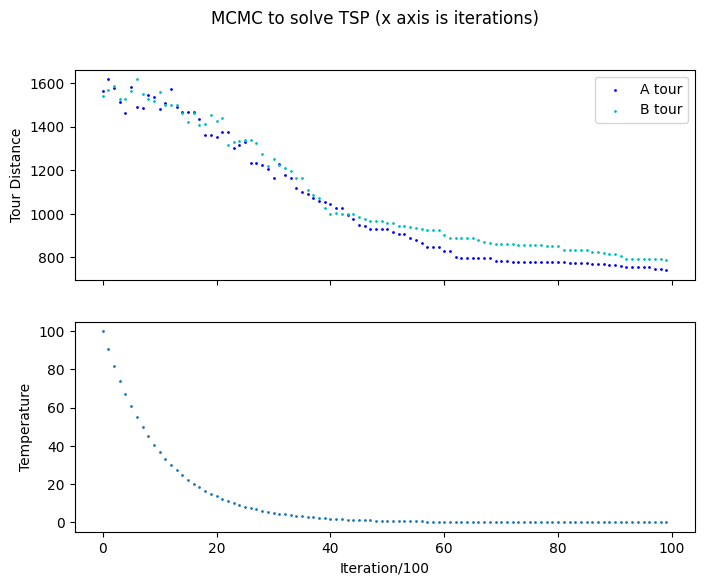

In [62]:
import matplotlib.pyplot as plt

ms = 1 # marker size

# Generate x-axis values (indices of the array)
indices = np.arange(len(tracking_data['dist_arr_a']))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('MCMC to solve TSP (x axis is iterations)')

# Create a line plot
ax1.scatter(indices, tracking_data['dist_arr_a'], c='b', marker='o', s=ms)
ax1.scatter(indices, tracking_data['dist_arr_b'], c='c', marker='o', s=ms)
ax1.legend(["A tour", "B tour"])
ax1.set_ylabel('Tour Distance')

ax2.scatter(indices, tracking_data['temp_arr'], marker='o', s=ms)
ax2.set_ylabel('Temperature')
ax2.set_xlabel('Iteration/100')


# Show the plot
plt.show()

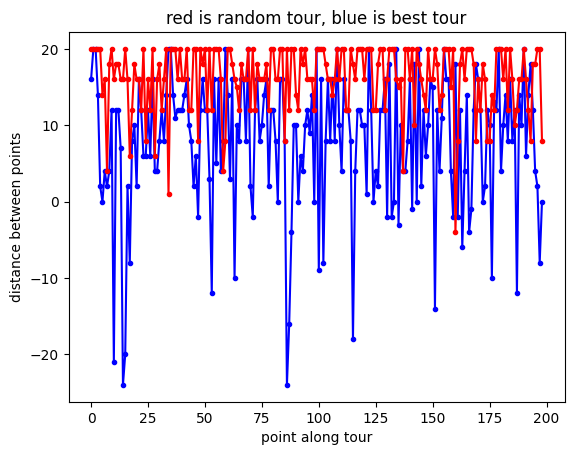

In [64]:
def get_tour_scores(tour):
    score_list = []
    for i in range(len(tour)-1):
        score_list.append(scores[tour[i], tour[i+1]])
    return score_list

random_tour = random.sample(list(range(len(data_raw))), len(data_raw))

best_score_list = get_tour_scores(best_tour)
rand_score_list = get_tour_scores(random_tour)

indices = np.arange(len(best_score_list))

# Create a line plot
plt.plot(indices, best_score_list, c='b', marker='.')
plt.plot(indices, rand_score_list, c='r', marker='.')

# Add titles and labels
plt.title('red is random tour, blue is best tour')
plt.xlabel('point along tour')
plt.ylabel('distance between points')

# Show the plot
plt.show()

[Text(0.5, 23.52222222222222, 'poem number'),
 Text(50.722222222222214, 0.5, 'tour number')]

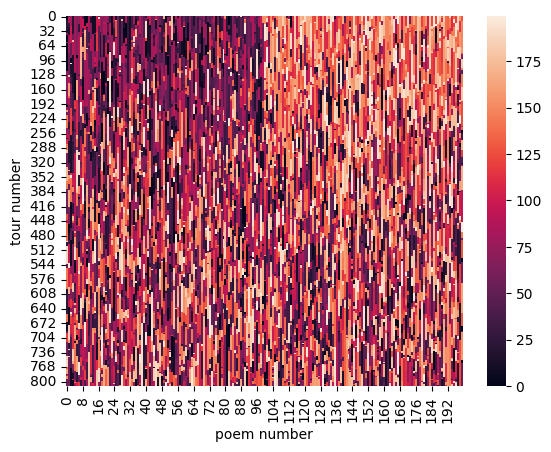

In [75]:
import seaborn as sns

ax = sns.heatmap(all_tours)
ax.set(xlabel = "poem number", ylabel="tour number")

## Step 5: Calculate breathing / break points

To let the poems breath a little bit, find the poems with the most distance between them to create more vertical space between some of the poems.

In [65]:
def get_break_points(tour, percent=20):
    """score_list returns the score of poem i to poem i+1, 
    so if a breakpoint has index i, the break should come
    after poem i."""
    score_list = get_tour_scores(tour)
    ordered = np.argsort(score_list)[::-1]
    return ordered[:percent]

get_break_points(best_tour)

array([ 99,   1,   2, 155, 108,  34, 190,  35, 122, 144, 179,  69,  59,
       134, 131, 169, 142, 160, 193, 129])

## Step 6: Calculate mixture levels

As book printing progresses, the mixture level should increase and then oscillate. Below is a simple function that lets the mixture level oscillate with some randomness while still increasing over time.

Text(0, 0.5, 'Mixture Level')

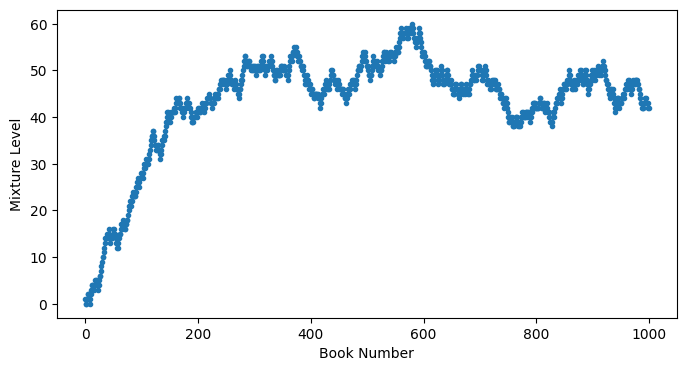

In [81]:
num_books = 1000

level = 0 # this is the mixture level
level_arr = np.empty(iterations)
for i in range(iterations):
    change = random.choices([-1,0,+1], weights=[level+20,50,120-level])[0]
    level = level + change
    level = min(max(0, level), 100)
    level_arr[i] = level


plt.figure(figsize=(8,4))
plt.scatter(range(len(level_arr)), level_arr, marker='.')
plt.xlabel('Book Number')
plt.ylabel('Mixture Level')

## Step 7: Let's write out the actual text of the books

In [88]:
print("finished book ", end="")
for book_num in range(10):
    mixture = int(level_arr[book_num])
    flename = f"booknum{book_num}-mix{mixture}.txt"
    tour, _ = solver(dist_matrix, iters, temp, mixture)
    breakpoints = get_break_points(tour)
    with open(f"output_books/{flename}", 'w') as fle:
        fle.write("PART 1\n\n\n\n")
        for k, index in enumerate(tour):
            if k == split_index:
                fle.write("\n\n***\n\n\n\nPART 2\n\n\n\n")
            if k in breakpoints:
                fle.write("\n\n***\n\n\n\n")
            poem = data_raw[index]
            fle.write(f"{poem}\n\n")
    print(book_num, end="...")

finished book 0...1...2...3...4...5...6...7...8...9...